## Code for Logistic Regression  without PCA

In [27]:
#importing all packages/libraries required
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
#downloadidng processed data and seperating predictor variables and the target variable
processed_data = pd.read_csv("processed_data.csv")
processed_data = processed_data.drop(columns = 'Unnamed: 0')
diabetes_data_predictors = processed_data

diabetes_data_predictors = processed_data.drop(columns="readmitted")

#splitting into X and y objects to perform train-test splitting
X, y = diabetes_data_predictors, processed_data["readmitted"]

#train test spplit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [29]:
#converting arrays generated from train-test split into pandas dataframe to allow undersampling
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

X = pd.concat([X_train, y_train], axis=1)

#seperating columns for not readmitted vs readmitted
not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

#performing undersampling of majority class (not readmitted) to train the model properly and improve model performance
not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = int(len(readmitted) * 1.25),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])

#seperating X and y objects that have been undersampled appropriately
y_train = downsampled.readmitted
X_train = downsampled.drop('readmitted', axis=1)

#performing another round of train test split to create new datasets needed to train model, and original testing dataset above will be evaluated with this model
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

#standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [30]:
#hyperparameter tuning for logistic regression model

#setting up a grid of parameters that can be assessed by gridsearch
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

#generating a model to perform gridsearch on, to tune the hyperparameters to optimize performance
logistic_regression = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
) 

#fitting grid seach parameters onto training set
grid_search.fit(X_train, y_train)

#identifying best parameters for logistic regression
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.6079358496527852


In [31]:
#training the final logistic regression model
final_model = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced')
final_model.fit(X_train, y_train)

#evaluating model on test dataset which is class balanced
y_pred_val = final_model.predict(X_val)


#accuracy and classification report on performance in balanced testing set
print("Test Accuracy:", accuracy_score(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))

Test Accuracy: 0.60076871657754
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.70      0.66      3322
           1       0.56      0.48      0.51      2662

    accuracy                           0.60      5984
   macro avg       0.59      0.59      0.59      5984
weighted avg       0.60      0.60      0.60      5984



In [32]:
#evaluating performance of model on original testing set that reflects real world balance
y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.6769670083116618
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79     17410
           1       0.16      0.46      0.24      2201

    accuracy                           0.68     19611
   macro avg       0.54      0.58      0.52     19611
weighted avg       0.83      0.68      0.73     19611



The AUC score for this logistic regression model is 0.6352892471518112


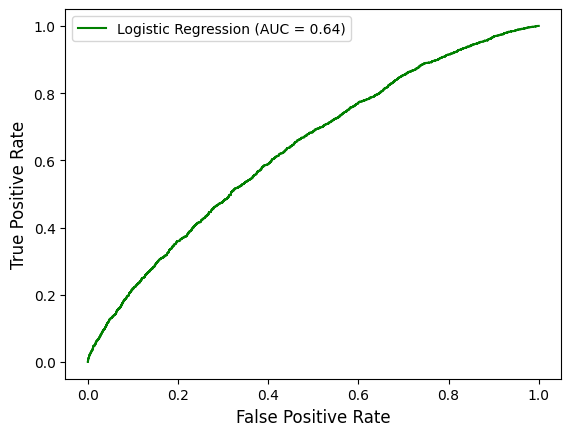

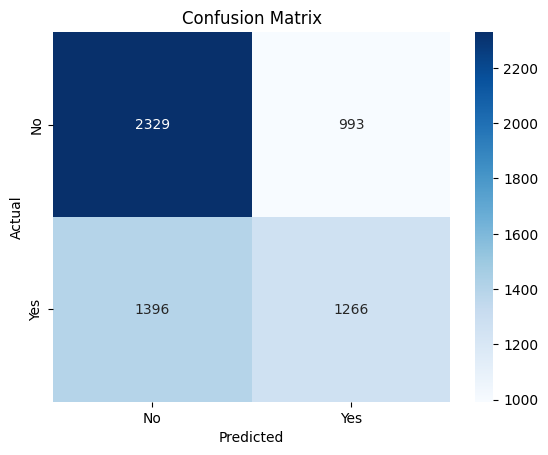

In [33]:
#identifyign probabilities of correct model prediction
X_test_probs = final_model.predict_proba(X_val)[::,1]

#computing ROC and AUC for logistic regression
lr_fpr, lr_tpr, _ = roc_curve(y_val, X_test_probs, pos_label=1)
lr_auc = roc_auc_score(y_val, X_test_probs)
print("The AUC score for this logistic regression model is", lr_auc)

#plotting auc curve
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})', color='green')
plt.legend()
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.show()

#creating a confusion matrix for logisitic regression model
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Performing logistic regression with PCA
Only change we have here is using PCA to extract maximum variation and reducing irrelevant variation

In [34]:
#performing train-test split on new objects
X1,y1 =diabetes_data_predictors, processed_data["readmitted"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=40)

#using same method to undersample the majority class to ensure model can be trained properly
X1_train = pd.DataFrame(X1_train)
y1_train = pd.DataFrame(y1_train)

X1 = pd.concat([X1_train, y1_train], axis=1)

not_readmitted_1 = X1[X1.readmitted==0]
readmitted_1 = X1[X1.readmitted==1]

#code shown below for undersampling and manipulating objects to seperate X and y
not_readmitted_sampled_1 = resample(not_readmitted_1,
                                replace = False, 
                                n_samples = int(len(readmitted_1) * 1.25),
                                random_state = 42)

downsampled_1 = pd.concat([not_readmitted_sampled_1, readmitted_1])

#setting X and y correctly
y1_train = downsampled_1.readmitted
X1_train = downsampled_1.drop('readmitted', axis=1)

#creating new train-test split objects
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size = 0.3, random_state = 42)

#scaling training and testing objects 
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_val)

#incorporating PCA to capture maximum variation on training and testing sets
pca = PCA(0.95)  # Keep 10 principal components
X1_train_pca = pca.fit_transform(X1_train_scaled)
X1_test_pca = pca.transform(X1_test_scaled)

#setting up grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

#searching for hyperparameters to optimize logistic regression model with PCA
logistic_regression_pca = LogisticRegression(max_iter=1000)
grid_search_pca = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
) 

#best hyperparameters for analysis
grid_search_pca.fit(X1_train_pca, y1_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.6079358496527852


In [35]:
#training the final model on balanced testing set
final_model_pca = LogisticRegression(C=0.01, penalty='l2', solver='liblinear', max_iter=1000, class_weight='balanced')
final_model_pca.fit(X1_train_pca, y1_train)

#evaluating model on test dataset from original split (class imbalanced)
y_pred_val_pca = final_model_pca.predict(X1_test_pca)


#accuracy and classification report evaluating metrics for performance
print("Test Accuracy:", accuracy_score(y1_val, y_pred_val_pca))
print("Classification Report:\n", classification_report(y1_val, y_pred_val_pca))

Test Accuracy: 0.6012700534759359
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.69      0.66      3322
           1       0.56      0.49      0.52      2662

    accuracy                           0.60      5984
   macro avg       0.59      0.59      0.59      5984
weighted avg       0.60      0.60      0.60      5984



The AUC score for this logistic regression model is 0.634238378933151


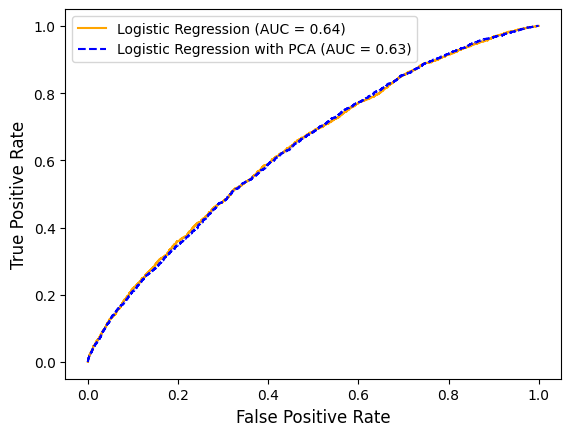

In [36]:
#predicting probability of final model
X_test_probs_pca = final_model_pca.predict_proba(X1_test_pca)[::,1]

#computing ROC and AUC for logistic regression
lr_fpr_pca, lr_tpr_pca, _ = roc_curve(y1_val, X_test_probs_pca, pos_label=1)
lr_auc_pca = roc_auc_score(y1_val, X_test_probs_pca)
print("The AUC score for this logistic regression model is", lr_auc_pca)

#plot comparing AUC for logistic regression model with and without PCA
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})', color='orange', linestyle = '-')
plt.plot(lr_fpr_pca, lr_tpr_pca, label=f'Logistic Regression with PCA (AUC = {lr_auc_pca:.2f})', color = 'blue', linestyle="--")
plt.legend()
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.savefig("lr_auc.png", dpi=300)

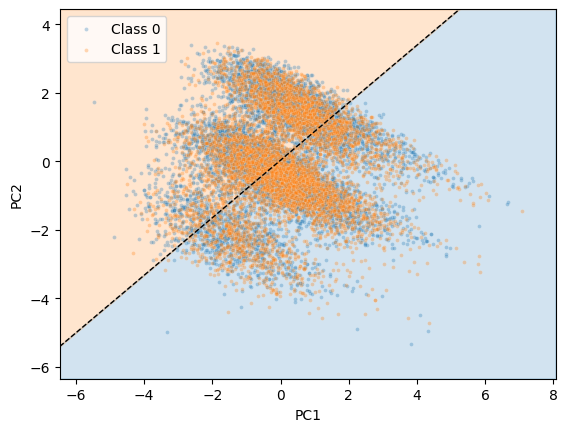

In [37]:
#creating boundary decision plot for logistic regression in PCA dimension space

#identifying the intercept for the pca model to where classification is
b = final_model_pca.intercept_[0] 

#coefficients that represent coordinates of PC1 and PC2
w1, w2 = final_model_pca.coef_[0][:2]  

#Calculate the intercept and gradient for the decision boundary in PCA space - allows to designate boundaries
c = -b / w2
m = -w1 / w2

#Create a range for x (PC1 values) for the decision boundary plot
xmin, xmax = X1_train_pca[:, 0].min() - 1, X1_train_pca[:, 0].max() + 1
ymin, ymax = X1_train_pca[:, 1].min() - 1, X1_train_pca[:, 1].max() + 1

#Create x-values for the decision boundary
xd = np.array([xmin, xmax])
yd = m * xd + c

#Plotting the decision boundary 
plt.plot(xd, yd, 'k', lw=1, ls='--')  

# Filling the areas that predict classification in each region
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

#Scatter plot of the data points that are the actual outcomes of patient readmission status
sns.scatterplot(x=X1_train_pca[y_train == 0][:, 0], y=X1_train_pca[y_train == 0][:, 1], 
                s=8, alpha=0.3, label="Class 0", color='tab:blue')
sns.scatterplot(x=X1_train_pca[y_train == 1][:, 0], y=X1_train_pca[y_train == 1][:, 1], 
                s=8, alpha=0.3, label="Class 1", color='tab:orange')

#plotting and saving image
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.legend()
plt.show()